# Repository Demo



Here is a flowchart for the actions that the tool takes.

Each of the following blocks are described in more detail through this notebook. Feel free to change parameters and experiment!

<p align="center">
  <img src="figures/flowchart_vertical.png" />
</p>

# 1. Getting Started

## 1.1 Ensure setup is accurate

### 1.1.1 System Requirements for TRELPy
- OS: Ubuntu (Has been tested to work on Ubuntu 20.04)
- Computer with GPU to run inference


### 1.1.2. Uncomment and run the following scripts to install all the pip and apt dependencies
```bash
pip3 install -r pip-requirements.txt &&
sudo apt-get -y update &&
sed 's/#.*//' apt-requirements.txt | xargs sudo apt-get -y install
```


### 1.1.3. Ensure all the following programs are installed.

|Name and link of program|What kind of installation| Versions tested on |
|-|-|-|
| [CUDA](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html) | Local, Docker | cuda_12.4.r12.4 |
| [STORM](https://www.stormchecker.org/documentation/obtain-storm/build.html) | Local | - |
| [PyTorch](https://pytorch.org/get-started/locally/) | Local | 2.1.0+cu12 |
| [StormPy](https://moves-rwth.github.io/stormpy/installation.html) | Local |  |
| [TuLiP](https://github.com/tulip-control/tulip-control) |  Local |  |
| [MMDetection3D](https://mmdetection3d.readthedocs.io/en/latest/get_started.html) | Local |  |
| [NVIDIA Container Toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html) | Local, Docker | 1.14.6 |
| [PRISM (Optional)](https://www.prismmodelchecker.org/manual/InstallingPRISM/Instructions) | Local |  |

**Local** means you are running on your ubuntu installation \
**Docker** means you will be using the provided Dockerfile. *This is currently a work in progress and not completely setup.*

### 1.1.4 Testing installation validity

In [1]:
import os
import sys
import subprocess
import numpy as np
import pickle as pkl
from pathlib import Path
from datetime import datetime
from pyquaternion import Quaternion
from itertools import chain, combinations
from typing import Tuple, Dict, Any, List
from confusion_matrix import ConfusionMatrix
from generate_confusion_matrix import GenerateConfusionMatrix

import torch

from nuscenes import NuScenes
from nuscenes.eval.common.config import config_factory
from nuscenes.eval.common.data_classes import EvalBoxes

Not creating /home/ranai/nuscenes_dataset/3D_Detection/saved_cms/lidar/mini/model2_good because it already exists


## 1.2. Setting up datasets

The NuScenes dataset can be downloaded from [this link after logging in](https://www.nuscenes.org/nuscenes#download:~:text=Show%20more%20%E2%86%93-,Downloads,-Here%20we%20list). \
Instructions for setting up nuscenes for working with MMDetection3D can be found at [MMDetection3D Dataset Preperation](https://mmdetection3d.readthedocs.io/en/latest/user_guides/dataset_prepare.html)

## 1.3. Getting setup for running inference

In this step, you will download and install a model so that you can begin running inference on the dataset you downloaded. \
\
**Config File** is a python file that contains parameters such as batch size, list of classes, indices, input size, etc.   
**Checkpoint File** is a `.pth` file which contains a the exact values of all parameters (weights, current learning rate, etc.) and stores all of this in non-volatile memory.

| Model Name | Modality |Link to Checkpoint file | Link to Config file | mAP (%) | Accuracy (%) | Link to paper |
|-|-|-|-|-|-|-|
|NuScenes SECFPN|Lidar|[Backbone file](https://download.openmmlab.com/mmdetection3d/v1.0.0_models/pointpillars/hv_pointpillars_secfpn_sbn-all_4x8_2x_nus-3d/hv_pointpillars_secfpn_sbn-all_4x8_2x_nus-3d_20210826_225857-f19d00a3.pth)|[Config File](https://github.com/open-mmlab/mmdetection3d/blob/main/configs/pointpillars/pointpillars_hv_secfpn_sbn-all_8xb4-2x_nus-3d.py)|34.33|49.1|[PointPillars](https://arxiv.org/abs/1812.05784)|
|NuScenes SECFPN(FP16)|Lidar|[Backbone file](https://github.com/open-mmlab/mmdetection3d/blob/main/configs/pointpillars/pointpillars_hv_secfpn_sbn-all_8xb2-amp-2x_nus-3d.py)|[Config file](https://download.openmmlab.com/mmdetection3d/v0.1.0_models/fp16/hv_pointpillars_secfpn_sbn-all_fp16_2x8_2x_nus-3d/hv_pointpillars_secfpn_sbn-all_fp16_2x8_2x_nus-3d_20201020_222626-c3f0483e.pth)|35.19|50.27|[PointPillars](https://arxiv.org/abs/1812.05784)|
|NuScenes FPN|Lidar|[Backbone file](https://github.com/open-mmlab/mmdetection3d/blob/main/configs/pointpillars/pointpillars_hv_fpn_sbn-all_8xb4-2x_nus-3d.py)|[Config File](https://download.openmmlab.com/mmdetection3d/v1.0.0_models/pointpillars/hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d/hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d_20210826_104936-fca299c1.pth)|39.7|53.2|[PointPillars](https://arxiv.org/abs/1812.05784)|
|NuScenes FPN (FP16)|Lidar|[Backbone file](https://github.com/open-mmlab/mmdetection3d/blob/main/configs/pointpillars/pointpillars_hv_fpn_sbn-all_8xb2-amp-2x_nus-3d.py)|[Config file](https://download.openmmlab.com/mmdetection3d/v0.1.0_models/fp16/hv_pointpillars_fpn_sbn-all_fp16_2x8_2x_nus-3d/hv_pointpillars_fpn_sbn-all_fp16_2x8_2x_nus-3d_20201021_120719-269f9dd6.pth)|39.2|53.2|[PointPillars](https://arxiv.org/abs/1812.05784)|
|-|-|-|-|-|-|-|
|BEVFusion|Lidar + Camera|[Backbone file](https://github.com/open-mmlab/mmdetection3d/blob/fe25f7a51d36e3702f961e198894580d83c4387b/projects/BEVFusion/configs/bevfusion_lidar_voxel0075_second_secfpn_8xb4-cyclic-20e_nus-3d.py)|[Config file](https://download.openmmlab.com/mmdetection3d/v1.1.0_models/bevfusion/bevfusion_lidar_voxel0075_second_secfpn_8xb4-cyclic-20e_nus-3d-2628f933.pth)|69.6|64.9|[BEVFusion](https://arxiv.org/abs/2205.13542)|

## 1.4 Setup your custom environment

The following cell contains content of the file `custom_env.py`. This is a configuration file that stores path variables, code parameters, etc. Once you fill out the following cell and run this notebook to ensure accuracy of this file, move the contents of this file to `custom_env.py`.

In [2]:
######## PARMS #########
## Inference model params ##
model_name = "model2_good"  # The name of the directory where the ML model for inference is stored
modality = "lidar"          # The modality of the data
is_mini = True              # Are you using this on NuScenes Mini?

## Confusion Matrix Generation Params ##
verbose = True
###### PARAMS END ######


####### Configuring the right dataset ########
# The code looks in mmdetection3d/data/ for a dataset folder or symlink called `dataset` to find a dataset with size `size`.
# The results will be stored in inside a folder titled `inference_results_path`
if is_mini:
    dataset = "nuscenes-mini"   
    size = "mini"
else:
    dataset = "nuscenes-full"
    size= "full"
    
########### METHODS #############
def getGitRoot():
    """Gets the root directory of the git repository

    Returns:
        str: path the denotes the root directory of the git repository
    """
    return subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')

def create_dir_if_not_exist(dir_path):
    if not os.path.exists(dir_path):
        print(f"Directory {dir_path} not found. Creating...")
        os.makedirs(dir_path)
    else:
        print(f"Not creating {dir_path} because it already exists")

def is_set_to_mini():
    return is_mini
###### METHODS END #########


home_dir = str(Path.home())
repo_dir = f"{home_dir}/nuscenes_dataset/3D_Detection"  #................# The directory where the repo is stored
dataset_root = f"{home_dir}/software/mmdetection3d/data/{dataset}/"  #...# The directory where the dataset is stored
output_dir = f"{home_dir}/inference_results/{dataset}/{model_name}" #....# The directory where the output of inference will be stored
model_dir  = f"{output_dir}/{model_name}" #..............................# The directory where the inference model is stored
preds_dir  = f"{model_dir}/preds" #......................................# The directory where inference predictions are stored
cm_dir = f"{repo_dir}/saved_cms/{modality}/{size}/{model_name}" #........# The directory where the confusion matrices generated by the tool will be stored 
create_dir_if_not_exist(cm_dir)

###########################
### Standard Parameters ###
eval_set_map = {
        'v1.0-mini': 'mini_val',
        'v1.0-trainval': 'val',
        'v1.0-test': 'test'
    }

dataset_version = 'v1.0-mini' if is_set_to_mini() else 'v1.0-trainval'

try:
    eval_version = 'detection_cvpr_2019'
    eval_config = config_factory(eval_version)
except:
    eval_version = 'cvpr_2019'
    eval_config = config_factory(eval_version)

cm_fn = f"{cm_dir}/low_thresh_cm.pkl"
prop_cm_fn = f"{cm_dir}/low_thresh_prop_cm.pkl"
prop_cm_seg_fn = f"{cm_dir}/low_thresh_prop_cm_cluster.pkl"
prop_dict_file = f"{cm_dir}/prop_dict.pkl"
control_dir = f"{repo_dir}/system_evaluation/controllers/"

Not creating /home/ranai/nuscenes_dataset/3D_Detection/saved_cms/lidar/mini/model2_good because it already exists


## 1.4. Ensure NuScenes is setup correctly

In [3]:

############# IMPORTS #############
## Usually you would use the following imports to get all necessary paths from the custom_env.py file

# from custom_env import dataset_root as dataroot
# from custom_env import cm_dir, model_dir, eval_version, eval_config
# from custom_env import is_set_to_mini, eval_set_map, dataset_version, eval_version 
##################################

# parameters to setup nuScenes

nusc = NuScenes(version=dataset_version, dataroot = dataset_root)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.399 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# 2. Run Inference

In [ ]:
## To run inference, change line 3 to `if True:`

if False:
    now = datetime.now()
    configs_path = "configs/pointpillars/pointpillars_hv_fpn_sbn-all_8xb4-2x_nus-3d.py"
    checkpoint_path = "checkpoints/hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d_20210826_104936-fca299c1.pth"

    folder_name = "model_"+now.strftime("%m-%d-%Y_%H_%M")
    out_dir = f"{output_dir}/" + folder_name

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    info_file = os.path.join(out_dir, "model_info.txt")
    with open(info_file, 'w') as f:
        f.write(f"configs_path = {configs_path} \n checkpoint_path = {checkpoint_path} \n")
    f.close()
        
    pcd_path = f"{dataset_root}/samples/LIDAR_TOP/"

    pcd_list = os.listdir(pcd_path)
    print(len(pcd_list))

    for i, pcd in enumerate(pcd_list):
        path = Path(f"{pcd_path}/{pcd}").absolute()
        if path.exists():
            cmd = f'python3 demo/pcd_demo.py {str(path)} {configs_path} {checkpoint_path} --device cuda --out-dir {out_dir}'
        
        ##### Uncomment this to run the inference ######    
        subprocess.run(cmd, cwd=f"{home_dir}/software/mmdetection3d/", shell=True)
        
        if i%100 == 0:
            print(f"---- ---- !-!-!-!- run_inference.py: Done with {i} files")

    with open(info_file, 'a') as f:
        f.write(f"Inferences complete.")
    f.close()

    print(f"Inference complete. Output written to {out_dir}")

# 3. Confusion Matrix Generation

## 3.1 Setup 

<p align="center">

In the following block, there are various variables that you can change to change the behavior of the Confusion Matrix Generation

| Variable name | Type | Description |
|--|--|--|
| `list of classes` | `list` | The class labels for the confsion matrix |
|`conf_mat_mapping`|`dict`| Dict ***keys*** represent output classes for inference |
|`conf_mat_mapping`|`dict`| Dict ***values*** represent the class lable to match it with |
| `labels` | `dict` | Dict ***keys*** represent place in the confusion matrix |
| `labels` | `dict` | Dict ***values*** represent place in the confusion matrix   |

</p>

<p align="left">
    <img src="figures/Distance_param.jpg" width=550px height=600px>
</p>

In [4]:
list_of_classes = ["ped", "obs"]        # The classes that are to be considered for the confusion matrix

PED = 0
OBS = 1
EMPTY = 2
                                        # TODO
labels = {0: "ped", 1: "obs", 2:"empty"}

conf_mat_mapping = {                    # The mapping from the output of the model to the classes in the confusion matrix
    "pedestrian": PED,
    "bus": OBS,
    "car" : OBS,
    "truck": OBS,
    "bicycle": OBS,
    "motorcycle": OBS,
    "traffic_cone": OBS
}

In [5]:
generator = GenerateConfusionMatrix(nusc=nusc,      
    config=eval_config,
    result_path=f'/home/ranai/nuscenes_dataset/inference_results_mini/model2_good/results_nusc.json',   ## PARAM Where are the results are stored
    eval_set=eval_set_map[dataset_version],
    output_dir=os.getcwd(), #.......................## PARAM Where to store the output
    verbose=verbose,  #.............................## PARAM Verbose
    conf_mat_mapping=conf_mat_mapping,
    list_of_classes=list_of_classes,
    distance_parametrized=True,
    max_dist=100, #................................## PARAM The maximum distance the model considers
    distance_bin=10 #..............................## PARAM For distance parametrized confusion matrices, the distance between radius bands
)

Initializing the generator
Loading ground truth and prediction boxes
Initializing nuScenes detection evaluation
Loaded results from /home/ranai/nuscenes_dataset/inference_results_mini/model2_good/results_nusc.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 484.09it/s]


Loaded ground truth annotations for 81 samples.
Results dir: /home/ranai/nuscenes_dataset/inference_results_mini/model2_good/results_nusc.json
Load boxes: No. of Pred tokens: 81
Load boxes: No. of GT tokens: 81
Filtering predictions
=> Original number of boxes: 2040
=> After distance based filtering: 2035
=> After LIDAR and RADAR points based filtering: 2035
=> After bike rack filtering: 2035
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR and RADAR points based filtering: 3393
=> After bike rack filtering: 3393
Completed filtering boxes
Loading ground truth and prediction boxes
Matching boxes
Match boxes completed.


## 3.2 Visualizing the scene

In [6]:
####### RENDERING LIBRARIES ######

from nuscenes_render import render_sample_data_with_predictions
from generate_confusion_matrix import convert_from_EvalBox_to_Box

--------- Details for sample 38a28a3aaf2647f2a8c0e90e31267bf8 ------------
Number of ground truth objects 44
Number of prediction objects 20


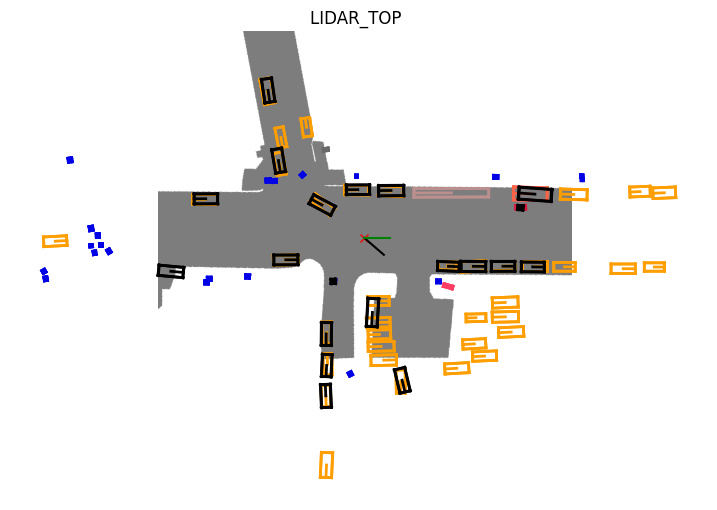

In [7]:
import random

random.seed = 42 # Change this number to visualize a different sample

sample_tokens = generator.gt_boxes.sample_tokens # All the sample tokens in the dataset

tok = random.choice(sample_tokens)
sample_data_token = nusc.get('sample', tok)['data']['LIDAR_TOP']

print(f"--------- Details for sample {tok} ------------")
print(f"Number of ground truth objects {len(generator.gt_boxes[tok])}")
print(f"Number of prediction objects {len(generator.pred_boxes[tok])}")

render_sample_data_with_predictions(nusc=nusc, 
                                    sample_data_token=sample_data_token, 
                                    pred_boxes=[convert_from_EvalBox_to_Box(obj) for obj in generator.pred_boxes[tok]], 
                                    verbose=True)



## Setup for probability plot generation



In [ ]:
# Common imports and functions:
from system_evaluation.print_utils import print_cm, print_param_cm
from system_evaluation.formula import *
import json

def get_confusion_matrix():
    C, param_C = cmp.confusion_matrix(cm_fn)
    return C, param_C

def init(MAX_V=6):
    Ncar = int(MAX_V*(MAX_V+1)/2 + 4)
    return Ncar

def save_results(INIT_V, P, P_param, result_type, true_env):
    results_folder = f"{cm_dir}/probability_results"
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    fname_v = Path(f"{results_folder}/{result_type}_cm_{true_env}_vmax_"+str(MAX_V)+"_initv.json")
    fname_p = Path(f"{results_folder}/{result_type}_cm_{true_env}_vmax_"+str(MAX_V)+"_prob.json")
    fname_param_p = Path(f"{results_folder}/{result_type}_param_cm_{true_env}_vmax_"+str(MAX_V)+"_prob.json")

    #pdb.set_trace()
    with open(fname_v, 'w') as f:
        json.dump(INIT_V, f)
    with open(fname_p, 'w') as f:
        json.dump(P, f)
    with open(fname_param_p, 'w') as f:
        json.dump(P_param, f)
        
def initialize(MAX_V, Ncar, maxv_init=None):
    '''
    Inputs::
    MAX_V: Maximum speed that the car can travel at
    Ncar: Maximum discrete states for the car
    vmax_init: Max initial speed of the car (specified if different from MAX_V)

    Outputs::
    Vlow: Minimum car speed (0)
    Vhigh: Maximum car speed (MAX_V)
    xped: Pedestrian position
    '''

    Vlow = 0
    Vhigh = MAX_V
    
    if maxv_init:
        xmax_stop = maxv_init*(maxv_init+1)/2 + 1 # earliest stopping point for car 
    else:
        xmax_stop = Vhigh*(Vhigh+1)/2 + 1 # earliest stopping point for car 
    
    xped, xcar_stop = set_crosswalk_cell(Ncar, xmax_stop)
    formula = formula_ev_good(xcar_stop, Vhigh, Vlow)
    return Vlow, Vhigh, xped, formula

In [ ]:
MAX_V = 6 # Max speed 

Class labeled system-level guarantees with the car-pedestrian example

In [ ]:
# Class Labeled CMs:
from system_evaluation.simple_markov_chain import construct_mc as cmp
from system_evaluation.simple_markov_chain.setup_mc import call_MC, call_MC_param

def simulate(MAX_V=6):
    Ncar = init(MAX_V=MAX_V)
    C, param_C = cmp.confusion_matrix(cm_fn)
    print(" =============== Full confusion matrix ===============")
    print_cm(C)
    print(" =============== Parametrized confusion matrix ===============")
    print_param_cm(param_C)
    print("===========================================================")
    INIT_V, P, P_param = compute_probabilities(Ncar, MAX_V, C, param_C,true_env_type="ped")
    save_results(INIT_V, P, P_param, "class", "ped")

def compute_probabilities(Ncar, MAX_V,C, param_C,true_env_type="ped"):
    INIT_V = []
    P = []
    P_param = []
    
    Vlow, Vhigh, xped, formula = initialize(MAX_V, Ncar)
    print("===========================================================")
    # Initial conditions set for all velocities
    print("Specification: ")
    print(formula)
    for vcar in range(1, MAX_V+1):  # Initial speed at starting point
        state_f = lambda x,v: (Vhigh-Vlow+1)*(x-1) + v
        start_state = "S"+str(state_f(1,vcar))
        print(start_state)
        S, state_to_S = cmp.system_states_example_ped(Ncar, Vlow, Vhigh)
        
        true_env = str(1) # Sidewalk 3
        O = {"ped", "obs", "empty"}
        class_dict = {0: {'ped'}, 1: {'obs'}, 2: {'empty'}}
        state_info = dict()
        state_info["start"] = start_state
    
        M = call_MC(S, O, state_to_S, C, class_dict, true_env, true_env_type, state_info, Ncar, xped, Vhigh)
        result = M.prob_TL(formula)
        P.append(result[start_state])

        param_M = call_MC_param(S, O, state_to_S, param_C, class_dict, true_env, true_env_type, state_info, Ncar, xped, Vhigh)
        result_param = param_M.prob_TL(formula)
        P_param.append(result_param[start_state])
        
        print('Probability of eventually reaching good state for initial speed, {}, and max speed, {} is p = {}:'.format(vcar, MAX_V, result[start_state]))
        # Store results:
        INIT_V.append(vcar)
            
    return INIT_V, P, P_param

simulate(MAX_V=MAX_V)

Now, we can compute system-level guarantees for the car-pedestrian example with proposition labeled confusion matrices for the full dataset.

In [ ]:
# Proposition Labeled CMs:
from system_evaluation.simple_markov_chain import prop_construct_mc as cmp
from system_evaluation.simple_markov_chain.setup_prop_mc import call_MC, call_MC_param

def simulate_prop(MAX_V=6):
    Ncar = init(MAX_V=MAX_V)
    C, param_C, prop_dict = cmp.confusion_matrix(prop_cm_fn, prop_dict_file)
    print(" =============== Proposition-based Full confusion matrix ===============")
    print_cm(C)
    print(" =============== Parametrized Proposition-based confusion matrix ===============")
    print_param_cm(param_C)
    print("===========================================================")
    INIT_V, P, P_param = compute_probabilities(Ncar, MAX_V,C, param_C, prop_dict)
    save_results(INIT_V, P, P_param, "prop", "ped")

def simulate_prop_seg(MAX_V=6):
    Ncar = init(MAX_V=MAX_V)
    C, param_C, prop_dict = cmp.confusion_matrix(prop_cm_seg_fn, prop_dict_file)
    print(" =============== Segmented Proposition-based Full confusion matrix ===============")
    print_cm(C)
    print(" =============== Segmented Parametrized Proposition-based confusion matrix ===============")
    print_param_cm(param_C)
    print("===========================================================")
    INIT_V, P, P_param = compute_probabilities(Ncar, MAX_V,C, param_C, prop_dict)
    save_results(INIT_V, P, P_param, "prop_seg", "ped")

def compute_probabilities(Ncar, MAX_V,C, param_C, label_dict, true_env_type="ped"):
    INIT_V = []
    P = []
    P_param = []
    Vlow, Vhigh, xped, formula = initialize(MAX_V, Ncar)
    print("===========================================================")
    # Initial conditions set for all velocities
    print("Specification: ")
    print(formula)
    for vcar in range(1, MAX_V+1):  # Initial speed at starting point
        state_f = lambda x,v: (Vhigh-Vlow+1)*(x-1) + v
        start_state = "S"+str(state_f(1,vcar))
        print(start_state)
        S, state_to_S = cmp.system_states_example_ped(Ncar, Vlow, Vhigh)
        
        true_env = str(1) # Sidewalk 3
        O = ["ped", "obs", ("ped","obs"), "empty"]
        state_info = dict()
        state_info["start"] = start_state
        
        M = call_MC(S, O, state_to_S, C, label_dict, true_env, true_env_type, state_info, Ncar, xped, Vhigh)
        result = M.prob_TL(formula)
        P.append(result[start_state])
        
        param_M = call_MC_param(S, O, state_to_S, param_C, label_dict, true_env, true_env_type, state_info, Ncar, xped, Vhigh)
        result_param = param_M.prob_TL(formula)
        P_param.append(result_param[start_state])

        print('Probability of eventually reaching good state for initial speed, {}, and max speed, {} is p = {}:'.format(vcar, MAX_V, result[start_state]))
        # Store results:
        INIT_V.append(vcar)
    
    return INIT_V, P, P_param

simulate_prop(MAX_V=MAX_V)
simulate_prop_seg(MAX_V=MAX_V)

Now, lets see the probabilities:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_probability(INIT_V, P, max_p, name, ax):
    max_p = update_max(P, max_p)
    ax.plot(INIT_V, P, 'o--', label=name)
    st()
    
def load_result(results_folder, res_type, true_env_type, MAX_V):
    try:
        fname_v = Path(f"{results_folder}/{res_type}_cm_{true_env_type}_vmax_"+str(MAX_V)+"_initv.json")
        fname_p = Path(f"{results_folder}/{res_type}_cm_{true_env_type}_vmax_"+str(MAX_V)+"_prob.json")
        fname_p_param = Path(f"{results_folder}/{res_type}_param_cm_{true_env_type}_vmax_"+str(MAX_V)+"_prob.json")
    except:
        st()
    
    with open(fname_v) as fv:
        INIT_V = json.load(fv)
    with open(fname_p) as fp:
        P = json.load(fp)
    with open(fname_p_param) as fp_param:
        P_param = json.load(fp_param)
    return INIT_V, P, P_param
    

def plot_results(results_folder, MAX_V, true_env_type):
    figure_folder = Path(f"{results_folder}/figures")
    if not os.path.exists(figure_folder):
        os.makedirs(figure_folder)
    fig_name = Path(f"{figure_folder}/guarantees_cm_{true_env_type}_vmax_"+str(MAX_V)+".png")

    fig, ax= plt.subplots()
    ax.tick_params(axis='both', which='major', labelsize=15)
    max_p = update_max()
    title = "System-level Guarantees"
    
    for res_type in ["class", "prop", "prop_seg"]:
        INIT_V, P, P_param = load_result(results_folder, res_type, true_env_type, MAX_V) 
        ax.plot(INIT_V, P, 'o--', label=res_type)
        ax.plot(INIT_V, P_param, 'o--', label=res_type+"_param")
        # plot_probability(INIT_V, P, max_p, res_type, ax)
        # plot_probability(INIT_V, P_param, max_p, res_type+"_param", ax)    
    
    leg = ax.legend(loc="best", fontsize=15)
    ax.set_xlabel("Initial speed",fontsize=15)
    ax.set_ylabel("Probability of satisfaction", fontsize=15)
    ax.set_xticks(np.arange(1,MAX_V+1,1))
    if title:
        ax.set_title(title,fontsize=20)
    y_upper_lim = min(1, max_p+0.1)
    ax.set_ylim(0,1)
    ax.get_figure().savefig(fig_name, format='png', dpi=400, bbox_inches = "tight")

results_folder = f"{cm_dir}/probability_results"
true_env_type = "ped"
plot_results(results_folder, MAX_V, true_env_type)

# Bibliography

```latex
@inproceedings{PointPillars,
  title={Pointpillars: Fast encoders for object detection from point clouds},
  author={Lang, Alex H and Vora, Sourabh and Caesar, Holger and Zhou, Lubing and Yang, Jiong and Beijbom, Oscar},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
  pages={12697--12705},
  year={2019}
}
```

```latex
@inproceedings{BevFusion,
  title={BEVFusion: Multi-Task Multi-Sensor Fusion with Unified Bird's-Eye View Representation},
  author={Liu, Zhijian and Tang, Haotian and Amini, Alexander and Yang, Xingyu and Mao, Huizi and Rus, Daniela and Han, Song},
  booktitle={IEEE International Conference on Robotics and Automation (ICRA)},
  year={2023}
}
```